In [83]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import math
from sklearn import datasets
from matplotlib import pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
warnings.filterwarnings("ignore")

In [2]:
real_X, real_Y = datasets.load_breast_cancer(return_X_y=True, as_frame=False)

In [3]:
def generate_and_fit(n_samples, n_irrel_variables, b, cv, n_rel_variables=5): 
    B = np.array([b]*(n_rel_variables) + [0.0]*(n_irrel_variables)).reshape(1, n_rel_variables+n_irrel_variables)
    X = np.random.normal(0, 1, size=(n_samples,n_rel_variables+n_irrel_variables))

    p = 1.0/(1.0 + np.exp(-B@X.T)).flatten()
    y = np.random.binomial(n=1, p=p)
    
    X = np.concatenate([X, np.ones(shape=(n_samples,1))], axis=1) # I add interecpt to data...
    if cv != 1:
        model = LogisticRegressionCV(penalty='l1', cv=cv, fit_intercept=False, solver='liblinear', max_iter=1000).fit(X, y) # ...so I skip intercept here
    else: 
        model = LogisticRegression(penalty='l1', fit_intercept=False, solver='liblinear', max_iter=1000).fit(X, y) # ...so I skip intercept here

    return X, y, model

- Fit one simple classification model, e.g. logistic regression or classification tree

#### Assess its performance. Estimate classification error using different schemes.
1. Refitting, i.e. use the whole dataset for both training and testing.

In [4]:
X, y, model = generate_and_fit(100, n_irrel_variables=5, b=1, cv=1)
model.score(X,y)

0.88

##### real dataset

In [5]:
model = LogisticRegression(penalty='l1', fit_intercept=False, solver='liblinear', max_iter=1000).fit(real_X, real_Y)
model.score(real_X, real_Y)

0.961335676625659

2. K-fold cross-validation (choose K = 5, 10, n).

In [6]:
X, y, model = generate_and_fit(100, n_irrel_variables=5, b=1, cv=5)
model.score(X,y)

0.81

In [7]:
sklearn wine datasetX, y, model = generate_and_fit(100, n_irrel_variables=5, b=1, cv=10)
model.score(X,y)

0.86

In [8]:
X, y, model = generate_and_fit(100, n_irrel_variables=5, b=1, cv=50) # I can't use K=n
# because sklearn give following error: n_splits=100 cannot be greater than the number of members in each class. 
model.score(X,y)

c:\users\krystian kurek\.conda\envs\mgr\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 49 members, which is less than n_splits=50.
  % (min_groups, self.n_splits)), UserWarning)


0.83

##### real dataset

In [9]:
model = LogisticRegressionCV(penalty='l1', fit_intercept=False, cv=5, solver='liblinear', max_iter=1000).fit(real_X, real_Y)
model.score(real_X, real_Y)

0.9806678383128296

In [10]:
model = LogisticRegressionCV(penalty='l1', fit_intercept=False, cv=10, solver='liblinear', max_iter=1000).fit(real_X, real_Y)
model.score(real_X, real_Y)

0.9876977152899824

In [11]:
model = LogisticRegressionCV(penalty='l1', fit_intercept=False, cv=len(real_X)//2, solver='liblinear', max_iter=1000).fit(real_X, real_Y)
model.score(real_X, real_Y)

c:\users\krystian kurek\.conda\envs\mgr\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 212 members, which is less than n_splits=284.
  % (min_groups, self.n_splits)), UserWarning)


0.9806678383128296

3. Boostrap method.
4. Boostrap 0.632.

In [12]:
def sample_once(X, y): 
    dataset = np.concatenate([X, y.reshape(-1, 1)], axis=1)
    sampled_indices = np.random.choice(range(len(dataset)), size=len(dataset))
    #sampled_dataset = np.random.choice([elem for elem in dataset], size=len(dataset))
    sampled_dataset = dataset[sampled_indices]
    not_sampled_indices = np.array([idx for idx in range(len(dataset)) if idx not in sampled_indices])
    return sampled_dataset[:, :-1], sampled_dataset[:, -1], not_sampled_indices
sample_once(X, y)

(array([[-1.80804249,  1.3295918 , -1.9244112 , ..., -0.83059753,
         -1.12940128,  1.        ],
        [-0.84394886, -1.75721616, -1.37312538, ..., -1.10517246,
         -1.48008699,  1.        ],
        [ 0.51058278,  0.40820785,  2.30066101, ...,  0.88636508,
         -1.8101896 ,  1.        ],
        ...,
        [-0.31265123,  1.6969594 ,  0.43603634, ..., -1.26684278,
         -1.05321661,  1.        ],
        [-0.05422438, -0.76544451, -1.09238016, ..., -0.03325863,
          0.20572574,  1.        ],
        [-0.05422438, -0.76544451, -1.09238016, ..., -0.03325863,
          0.20572574,  1.        ]]),
 array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
        0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0

In [13]:
n_iter = 100
def bootstrap(n_iter, X, y):
    estimators_scores = []
    y_preds = []
    for i in range(n_iter): 
        new_X, new_y, not_sampled_indices = sample_once(X, y)
        model = LogisticRegression(penalty='l1', fit_intercept=False, solver='liblinear', max_iter=1000).fit(new_X, new_y)
        # tutaj trzeba tylko na nieuzytych 
        y_preds.append(model.predict(X[not_sampled_indices]).reshape(-1, 1) == y[not_sampled_indices].reshape(-1, 1))

        estimators_scores.append(model.score(X, y))

    # dla estymatorow
    estimators_score = (1 - np.array(estimators_scores)).mean()
    # dla próbek
    sample_score = np.array([(1 - y_pred.astype(np.int32)).mean() for y_pred in y_preds]).mean() 
    return estimators_score, sample_score*(1. - 1./math.e) + estimators_score/math.e,  sample_score
bootstrap(n_iter, X, y)

(0.2091, 0.2467018384792352, 0.2685852326096128)

##### true dataset

In [16]:
bootstrap(n_iter, real_X, real_Y)

(0.04065026362038665, 0.04526756569914915, 0.04795472795756825)

- c) For artificial dataset, try different values of n, k and b.

Text(0.5, 0, 'N')

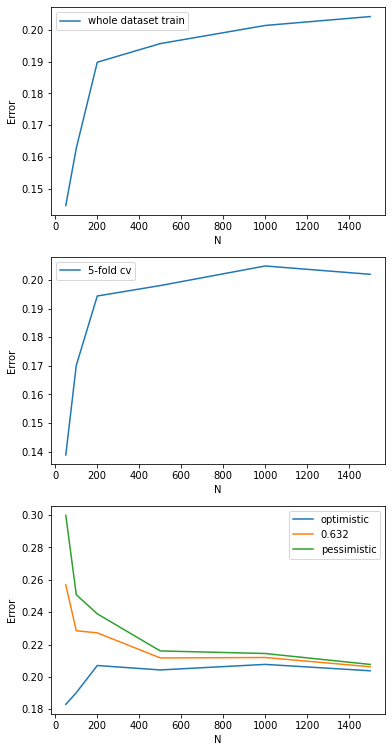

In [47]:
L = 50
n = [50, 100, 200, 500, 1000, 1500]
whole_dataset_errors = []
cv_errors = []
bootstrap_errors = []
for n_samples in n:
    whole_dataset_errors_tmp = []
    cv_errors_tmp = []
    bootstrap_errors_tmp = []
    for _ in range(L):
        # 1. Refitting, i.e. use the whole dataset for both training and testing.
        X, y, model = generate_and_fit(n_samples, n_irrel_variables=5, b=1, cv=1)
        whole_dataset_error = 1.0 - model.score(X, y)
        # 2. K-fold cross-validation (choose K = 5, 10, n).
        X, y, model = generate_and_fit(n_samples, n_irrel_variables=5, b=1, cv=5)
        cv_error = 1.0 - model.score(X, y)
        # 3. Boostrap method.
        # 4. Boostrap 0.632.
        optimistic, b_623, pessimistic = bootstrap(10, X, y)
        
        whole_dataset_errors_tmp.append(whole_dataset_error)
        cv_errors_tmp.append(cv_error)
        bootstrap_errors_tmp.append((optimistic, b_623, pessimistic))
    
    whole_dataset_errors.append(np.array(whole_dataset_errors_tmp).mean())
    cv_errors.append(np.array(cv_errors_tmp).mean())
    bootstrap_errors.append(np.array(bootstrap_errors_tmp).mean(axis=0).reshape(1, -1))
fig, axs = plt.subplots(nrows=3, figsize=(6, 13))

axs[0].plot(n, whole_dataset_errors, label='whole dataset train')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_xlabel('N samples')

axs[1].plot(n, cv_errors, label='5-fold cv')
axs[1].legend()
axs[1].set_ylabel('Error')
axs[1].set_xlabel('N samples')

bootstrap_errors = np.concatenate(bootstrap_errors, axis=0)
axs[2].plot(n, bootstrap_errors[:, 0], label='optimistic')
axs[2].plot(n, bootstrap_errors[:, 1], label='0.632')
axs[2].plot(n, bootstrap_errors[:, 2], label='pessimistic')

axs[2].legend()
axs[2].set_ylabel('Error')
axs[2].set_xlabel('N samples')


Text(0.5, 0, '# irrelevant variables')

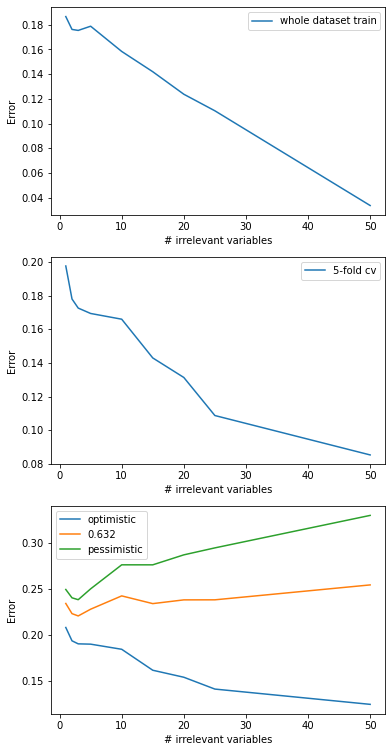

In [49]:
L = 50
n_irrel_variables = [1,2,3,5,10,15,20,25,50]
whole_dataset_errors = []
cv_errors = []
bootstrap_errors = []
for n_irrel in n_irrel_variables:
    whole_dataset_errors_tmp = []
    cv_errors_tmp = []
    bootstrap_errors_tmp = []
    for _ in range(L):
        # 1. Refitting, i.e. use the whole dataset for both training and testing.
        X, y, model = generate_and_fit(100, n_irrel_variables=n_irrel, b=1, cv=1)
        whole_dataset_error = 1.0 - model.score(X, y)
        # 2. K-fold cross-validation (choose K = 5, 10, n).
        X, y, model = generate_and_fit(100, n_irrel_variables=n_irrel, b=1, cv=5)
        cv_error = 1.0 - model.score(X, y)
        # 3. Boostrap method.
        # 4. Boostrap 0.632.
        optimistic, b_623, pessimistic = bootstrap(10, X, y)
        
        whole_dataset_errors_tmp.append(whole_dataset_error)
        cv_errors_tmp.append(cv_error)
        bootstrap_errors_tmp.append((optimistic, b_623, pessimistic))
    
    whole_dataset_errors.append(np.array(whole_dataset_errors_tmp).mean())
    cv_errors.append(np.array(cv_errors_tmp).mean())
    bootstrap_errors.append(np.array(bootstrap_errors_tmp).mean(axis=0).reshape(1, -1))
fig, axs = plt.subplots(nrows=3, figsize=(6, 13))

axs[0].plot(n_irrel_variables, whole_dataset_errors, label='whole dataset train')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_xlabel('# irrelevant variables')

axs[1].plot(n_irrel_variables, cv_errors, label='5-fold cv')
axs[1].legend()
axs[1].set_ylabel('Error')
axs[1].set_xlabel('# irrelevant variables')

bootstrap_errors = np.concatenate(bootstrap_errors, axis=0)
axs[2].plot(n_irrel_variables, bootstrap_errors[:, 0], label='optimistic')
axs[2].plot(n_irrel_variables, bootstrap_errors[:, 1], label='0.632')
axs[2].plot(n_irrel_variables, bootstrap_errors[:, 2], label='pessimistic')

axs[2].legend()
axs[2].set_ylabel('Error')
axs[2].set_xlabel('# irrelevant variables')


Text(0.5, 0, 'value of b')

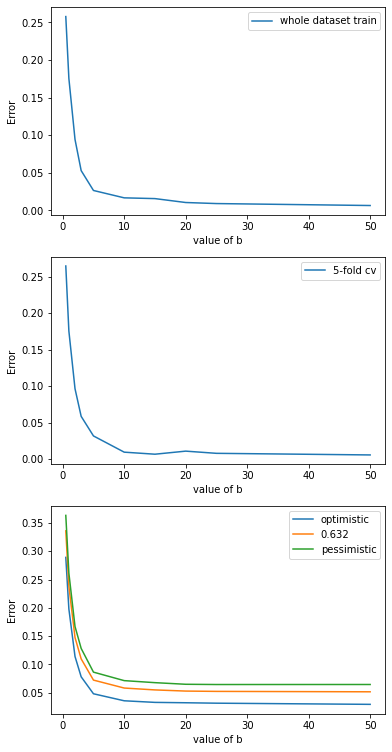

In [50]:
L = 50
bs = [0.5, 1,2,3,5,10,15,20,25,50]
whole_dataset_errors = []
cv_errors = []
bootstrap_errors = []
for b in bs:
    whole_dataset_errors_tmp = []
    cv_errors_tmp = []
    bootstrap_errors_tmp = []
    for _ in range(L):
        # 1. Refitting, i.e. use the whole dataset for both training and testing.
        X, y, model = generate_and_fit(100, n_irrel_variables=5, b=b, cv=1)
        whole_dataset_error = 1.0 - model.score(X, y)
        # 2. K-fold cross-validation (choose K = 5, 10, n).
        X, y, model = generate_and_fit(100, n_irrel_variables=5, b=b, cv=5)
        cv_error = 1.0 - model.score(X, y)
        # 3. Boostrap method.
        # 4. Boostrap 0.632.
        optimistic, b_623, pessimistic = bootstrap(10, X, y)
        
        whole_dataset_errors_tmp.append(whole_dataset_error)
        cv_errors_tmp.append(cv_error)
        bootstrap_errors_tmp.append((optimistic, b_623, pessimistic))
    
    whole_dataset_errors.append(np.array(whole_dataset_errors_tmp).mean())
    cv_errors.append(np.array(cv_errors_tmp).mean())
    bootstrap_errors.append(np.array(bootstrap_errors_tmp).mean(axis=0).reshape(1, -1))
fig, axs = plt.subplots(nrows=3, figsize=(6, 13))

axs[0].plot(bs, whole_dataset_errors, label='whole dataset train')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_xlabel('value of b')

axs[1].plot(bs, cv_errors, label='5-fold cv')
axs[1].legend()
axs[1].set_ylabel('Error')
axs[1].set_xlabel('value of b')

bootstrap_errors = np.concatenate(bootstrap_errors, axis=0)
axs[2].plot(bs, bootstrap_errors[:, 0], label='optimistic')
axs[2].plot(bs, bootstrap_errors[:, 1], label='0.632')
axs[2].plot(bs, bootstrap_errors[:, 2], label='pessimistic')

axs[2].legend()
axs[2].set_ylabel('Error')
axs[2].set_xlabel('value of b')


2) Consider datasets from the previous task.

a) Implement your own function to draw curves. Consider two types of curves:
- ROC curves.

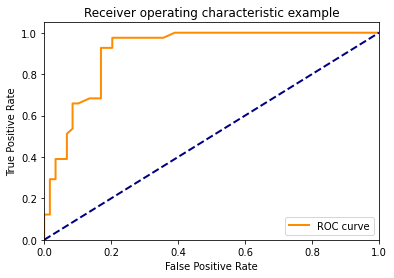

In [124]:
def calculate_TRP(y_true, y_pred):
    # TP/(TP+FN)
    TP = ((y_true == 1) & (y_pred == 1)).astype(np.int32).sum()
    FN = ((y_true == 1) & (y_pred == 0)).astype(np.int32).sum()
    return TP/(TP+FN) if TP+FN else 0  
    
def calculate_FPR(y_true, y_pred): 
    # FP/(FP+TN)
    FP = ((y_true == 0) & (y_pred == 1)).astype(np.int32).sum()
    TN = ((y_true == 0) & (y_pred == 0)).astype(np.int32).sum()
    return FP/(FP+TN) if FP+TN else 0  
    
def roc_curve(y_true, score, n=100):
    min_score, max_score = 0, 1
    TPRs, FPRs = [], []
    for split in np.linspace(min_score, max_score, n): 
        y_pred = (score > split).astype(np.int32)
        TPR = calculate_TRP(y_true, y_pred)
        FPR = calculate_FPR(y_true, y_pred)
        TPRs.append(TPR)
        FPRs.append(FPR)
    return TPRs, FPRs

def plot_roc(y_true, scores):
    TPRs, FPSs = roc_curve(y_true, scores[:, 1])
    plt.figure()
    plt.plot(FPSs, TPRs, color="darkorange",lw=2,label="ROC curve")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    
X, y, model = generate_and_fit(100, n_irrel_variables=5, b=1, cv=1)
scores = model.predict_proba(X)
plot_roc(y, scores)

- Recall-precision curves.

In [125]:
from sklearn.metrics import precision_score, classification_report, confusion_matrix
y1 = np.random.choice([0,1], 50)
y2 = np.random.choice([0,1], 50)
calculate_precision(y1, y2), precision_score(y1, y2)

(0.4, 0.4)

In [126]:
y1 = np.random.choice([0,1], 50)
y2 = np.random.choice([0,1], 50)
calculate_TRP(y1, y2), classification_report(y1, y2, output_dict=True)['1']['recall']

(0.6666666666666666, 0.6666666666666666)

In [127]:
y1 = np.random.choice([0,1], 50)
y2 = np.random.choice([0,1], 50)
tn, fp, fn, tp = confusion_matrix(y1, y2).flatten()
calculate_FPR(y1, y2), fp/(fp+tn)

(0.44, 0.44)

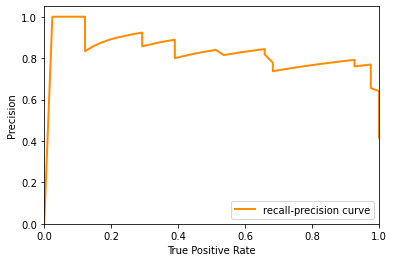

In [128]:
def calculate_precision(y_true, y_pred): 
    # TP/(TP+FP)
    TP = ((y_true == 1) & (y_pred == 1)).astype(np.int32).sum()
    FP = ((y_true == 0) & (y_pred == 1)).astype(np.int32).sum()
    return TP/(TP+FP) if TP+FP else 0  

def recall_precision_curve(y_true, score, n=100):
    min_score, max_score = 0.001, 1
    TPRs, precisions = [], []
    for split in np.linspace(min_score, max_score, n): 
        y_pred = (score > split).astype(np.int32)
        TPR = calculate_TRP(y_true, y_pred)
        precision = calculate_precision(y_true, y_pred)
        TPRs.append(TPR)
        precisions.append(precision)
    return TPRs, precisions

def plot_rp(y_true, scores, ax=None):
    TPRs, precisions = recall_precision_curve(y_true, scores[:, 1])
    plt.figure()
    plt.plot(TPRs, precisions, color="darkorange",lw=2,label="recall-precision curve")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel("Precision")
    plt.xlabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
plot_rp(y, scores)

b) In the case of real datasets, draw curves corresponding to 3 different classifiers. You can
choose e.g. LDA, logistic model and classification tree.

In [129]:
train_X, test_X, train_Y, test_Y = train_test_split(real_X, real_Y)

In [130]:
gscv = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5).fit(real_X, real_Y)
gscv.best_params_

{'ccp_alpha': 0.012499999999999999, 'max_depth': 5}

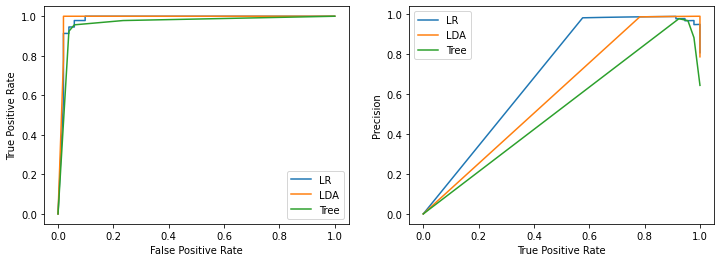

In [131]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))

alphas = np.linspace(0, 0.3, 25)
parameters = {'ccp_alpha': alphas,
             'max_depth': [1,3,5]}

models = {'LR': LogisticRegression, 
          'LDA': LinearDiscriminantAnalysis, 
          'Tree': DecisionTreeClassifier}

args = {'LR': {'penalty': 'l1', 
               'solver': 'liblinear', 
               'max_iter': 1000}, 
          'LDA': {}, 
          'Tree': gscv.best_params_}


for i, (model_name, model) in enumerate(models.items()): 
    model = model(**args[model_name]).fit(train_X, train_Y)
    scores = model.predict_proba(test_X)
    TPRs, FPRs = roc_curve(test_Y, scores[:, 1], n=100)
    TPRs, precisions = recall_precision_curve(test_Y, scores[:, 1], n=100)
    axs[0].plot(FPRs, TPRs, label=model_name)
    axs[1].plot(TPRs, precisions, label=model_name)
    

    
axs[0].legend()
axs[1].legend()

axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")


axs[1].set_ylabel("Precision")
_ = axs[1].set_xlabel("True Positive Rate")

c) In the case of artificial dataset, draw curves corresponding to different values of parameters
b, k, n.

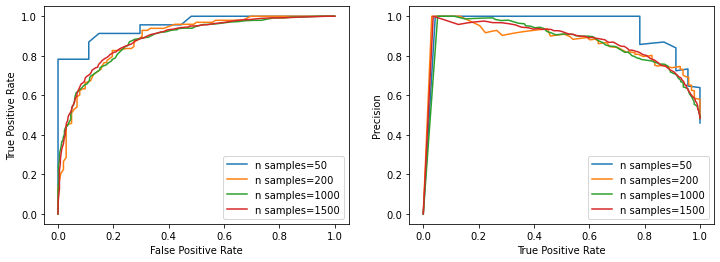

In [136]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))

n = [50, 200, 1000, 1500]
for n_samples in n:
    # 1. Refitting, i.e. use the whole dataset for both training and testing.
    X, y, model = generate_and_fit(n_samples, n_irrel_variables=5, b=1, cv=1)
    scores = model.predict_proba(X)
    TPRs, FPRs = roc_curve(y, scores[:, 1], n=100)
    TPRs, precisions = recall_precision_curve(y, scores[:, 1], n=100)
    axs[0].plot(FPRs, TPRs, label=f'n samples={n_samples}')
    axs[1].plot(TPRs, precisions, label=f'n samples={n_samples}')
    

    
axs[0].legend()
axs[1].legend()

axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")


axs[1].set_ylabel("Precision")
_ = axs[1].set_xlabel("True Positive Rate")

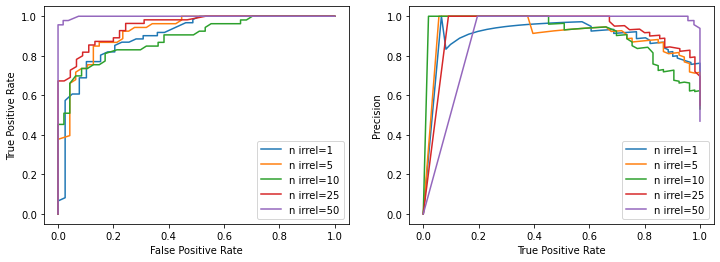

In [133]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
n_irrel_variables = [1,5,10,25, 50]

for n_irrel in n_irrel_variables:
    # 1. Refitting, i.e. use the whole dataset for both training and testing.
    X, y, model = generate_and_fit(100, n_irrel_variables=n_irrel, b=1, cv=1)
    scores = model.predict_proba(X)
    TPRs, FPRs = roc_curve(y, scores[:, 1], n=100)
    TPRs, precisions = recall_precision_curve(y, scores[:, 1], n=100)
    axs[0].plot(FPRs, TPRs, label=f'n irrel={n_irrel}')
    axs[1].plot(TPRs, precisions, label=f'n irrel={n_irrel}')
    

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")


axs[1].set_ylabel("Precision")
_ = axs[1].set_xlabel("True Positive Rate")

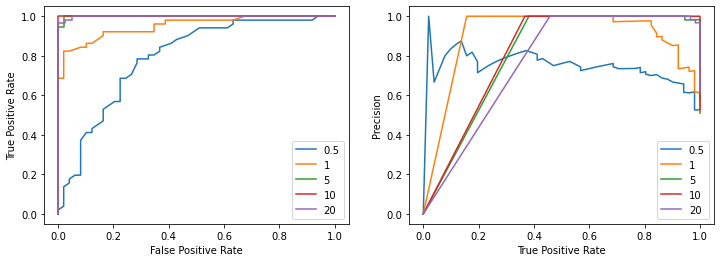

In [132]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
bs = [0.5, 1,5,10,20]

for b in bs:
    # 1. Refitting, i.e. use the whole dataset for both training and testing.
    X, y, model = generate_and_fit(100, n_irrel_variables=5, b=b, cv=1)
    scores = model.predict_proba(X)
    TPRs, FPRs = roc_curve(y, scores[:, 1], n=100)
    TPRs, precisions = recall_precision_curve(y, scores[:, 1], n=100)
    axs[0].plot(FPRs, TPRs, label=f'b={b}')
    axs[1].plot(TPRs, precisions, label=f'b={b}')
    

    
axs[0].legend()
axs[1].legend()

axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")


axs[1].set_ylabel("Precision")
_ = axs[1].set_xlabel("True Positive Rate")